In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Load dataset
df = pd.read_csv('data/results.csv')

# Convert result time to total seconds
def convert_result_to_seconds(result_str):
    try:
        parts = result_str.split(':')
        if len(parts) == 2:
            minutes = int(parts[0])
            seconds = float(parts[1])
            return minutes * 60 + seconds
        else:
            return np.nan
    except:
        return np.nan
# creating new column

df['Result_sec'] = df['Result'].apply(convert_result_to_seconds)

# focus on 800M men as starting point
event_name = "800M Men"
event_df = df[df['Event'] == event_name]

event_name2 = "800M Women"
event_df2 = df[df['Event'] == event_name2]

# Pivot to get a time series of medal results over the years
pivot_df = event_df.pivot_table(index='Year', columns='Medal', values='Result_sec', aggfunc='mean').sort_index()
pivot_df2 = event_df2.pivot_table(index='Year', columns='Medal', values='Result_sec', aggfunc='mean').sort_index()



,Gender,Event,Location,Year,Medal,Name,Nationality,Result,Result_sec
2026,W,800M Women,Rio,2016,G,Caster SEMENYA,RSA,1:55.28,115.28
2027,W,800M Women,Rio,2016,S,Francine NIYONSABA,BDI,1:56.49,116.49
2028,W,800M Women,Rio,2016,B,Margaret Nyairera WAMBUI,KEN,1:56.89,116.89
2029,W,800M Women,Beijing,2008,G,Pamela JELIMO,KEN,1:54.87,114.87
2030,W,800M Women,Beijing,2008,S,Janeth Jepkosgei BUSIENEI,KEN,1:56.07,116.07


In [ ]:
df['Year'].unique()

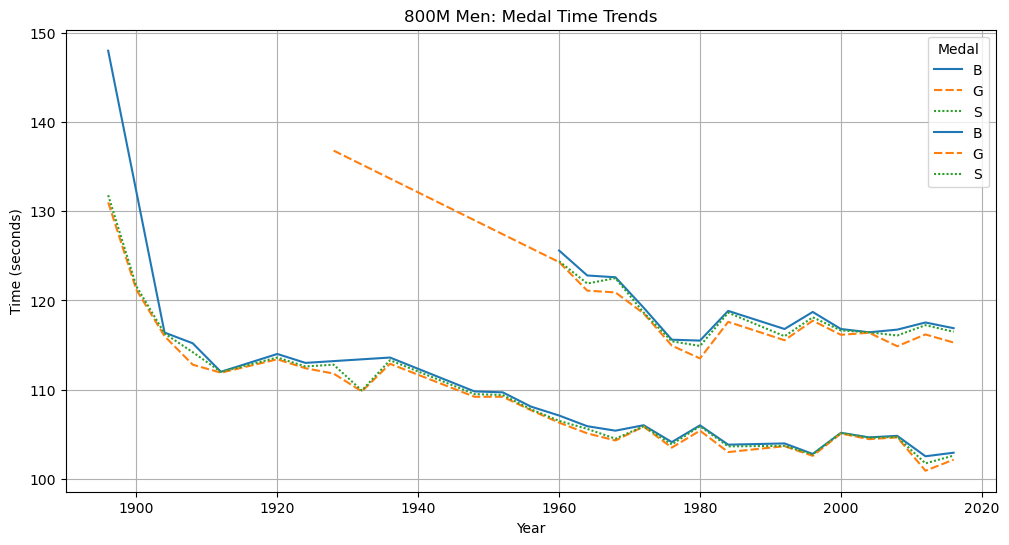

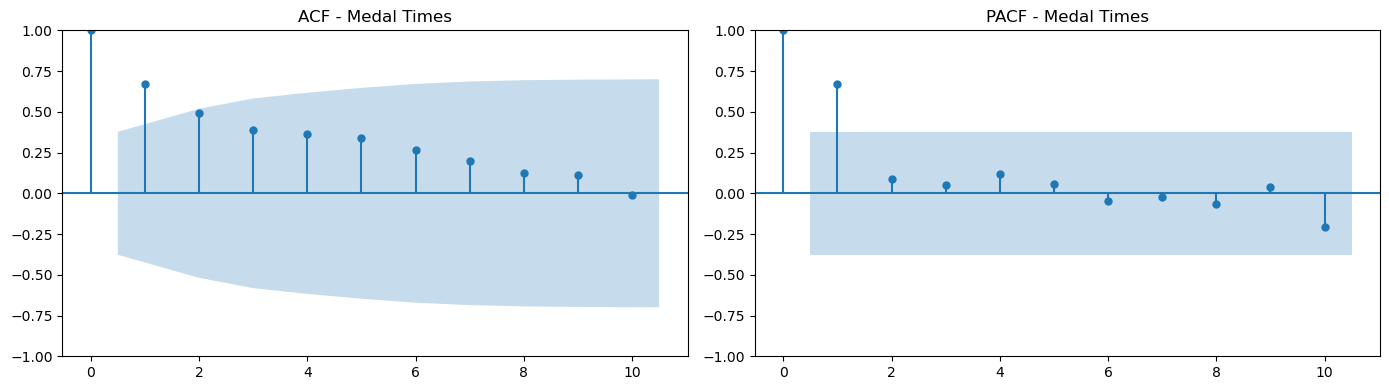

In [3]:
# line plot for medal trends over time
plt.figure(figsize=(12, 6))
sns.lineplot(data=pivot_df)
sns.lineplot(data = pivot_df2)
plt.title(f'{event_name}: Medal Time Trends')
plt.ylabel('Time (seconds)')
plt.xlabel('Year')
plt.legend(title='Medal')
plt.grid(True)
#plt.tight_layout()
plt.show()

# ACF & PACF plots for chosen medal times
gold_series = pivot_df['G'].dropna()

fig, axes = plt.subplots(1, 2, figsize=(14, 4))
plot_acf(gold_series, lags=10, ax=axes[0])
plot_pacf(gold_series, lags=10, ax=axes[1])
axes[0].set_title("ACF - Medal Times")
axes[1].set_title("PACF - Medal Times")
plt.tight_layout()
plt.show()


In [ ]:
#ACF - how strongly data correlates with lags
#PACF - identify significant number of lags
#both models taper off slowly... ARIMA model might be best?

/Users/avaduggan/miniconda3/envs/ds/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/Users/avaduggan/miniconda3/envs/ds/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/Users/avaduggan/miniconda3/envs/ds/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/Users/avaduggan/miniconda3/envs/ds/lib/python3.9/site-packages/statsmodels/tsa/base/

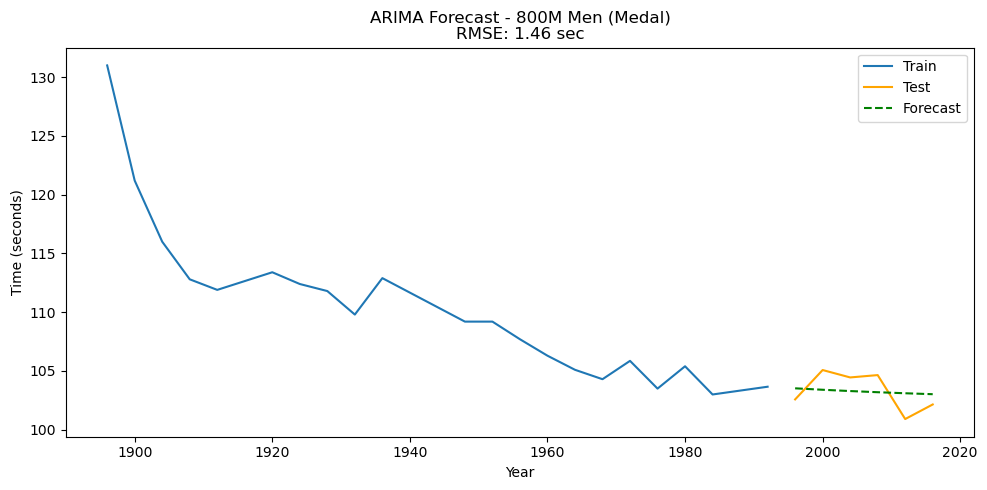

ARIMA RMSE: 1.46 seconds


,Year,Actual,ARIMA_Forecast
0,1996,102.58,103.523862
1,2000,105.08,103.401492
2,2004,104.45,103.291497
3,2008,104.65,103.192626
4,2012,100.91,103.103754


In [4]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# looking at gold medal time series for the selected event
gold_series = pivot_df['G'].dropna()

# training and test sets
train_size = int(len(gold_series) * 0.8)
train, test = gold_series[:train_size], gold_series[train_size:]

#will want to explore different arima model orders
# p: # of lags model uses to predict 
# d: ...
# q: moving average 

model = ARIMA(train, order=(1, 1, 1))
model_fit = model.fit()

# forecasting test set length
forecast = model_fit.forecast(steps=len(test))

# rmse
rmse = np.sqrt(mean_squared_error(test, forecast))

# actual vs forecasted values
plt.figure(figsize=(10, 5))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test', color='orange')
plt.plot(test.index, forecast, label='Forecast', linestyle='--', color='green')
plt.title(f'ARIMA Forecast - {event_name} (Medal)\nRMSE: {rmse:.2f} sec')
plt.ylabel('Time (seconds)')
plt.xlabel('Year')
plt.legend()
plt.tight_layout()
plt.show()

# df to observe actual vs forecasted
comparison_df = pd.DataFrame({
    'Year': test.index,
    'Actual': test.values,
    'ARIMA_Forecast': forecast.values
}).reset_index(drop=True)

# Display the RMSE
print(f"ARIMA RMSE: {rmse:.2f} seconds")
comparison_df.head()


In [5]:
import warnings


def compute_arima_rmse_by_event(df, order):
    results = []
    df = df.copy()  # avoid modifying the original df

    # result column to seconds
    df['Result_sec'] = df['Result'].apply(convert_result_to_seconds)

    group_cols = ['Gender', 'Event', 'Medal']
    for (gender, event, medal), group in df.groupby(group_cols):
        series = group[['Year', 'Result_sec']].dropna().sort_values('Year')
        # want appropriate number of time points per event

        ts = series.drop_duplicates(subset='Year').set_index('Year')['Result_sec']
        ts.index = pd.PeriodIndex(ts.index, freq='Y')
        
        train_size = int(len(ts) * 0.8)
        train = ts[:train_size]
        test = ts[train_size:]

        if len(test) < 2:
            continue

        try:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")  # suppress ARIMA warnings only here

                model = ARIMA(train, order=order)
                model_fit = model.fit()
                forecast = model_fit.forecast(steps=len(test))
                forecast.index = test.index

                rmse = np.sqrt(mean_squared_error(test, forecast))

            results.append({
                'Gender': gender,
                'Event': event,
                'Medal': medal,
                'RMSE': rmse
            })

        except Exception as e:
            continue

    results_df = pd.DataFrame(results)
    return results_df.sort_values(by='RMSE', ascending=True).reset_index(drop=True)

rmse_sorted_df1 = compute_arima_rmse_by_event(df, order = (1,1,1))
print("RMSE for gender, event, medal combinations with order (1,1,1):\n", rmse_sorted_df1)

RMSE for gender, event, medal combinations with order (1,1,1):
    Gender                   Event Medal       RMSE
0       W              800M Women     S   0.904729
1       W              800M Women     G   0.996150
2       M        4X400M Relay Men     B   1.356019
3       M                800M Men     B   1.378475
4       M        4X400M Relay Men     G   1.388935
5       W              800M Women     B   1.409190
6       M                800M Men     G   1.457769
7       M                800M Men     S   1.471962
8       M        4X400M Relay Men     S   2.002239
9       W      4X400M Relay Women     G   2.156315
10      W      4X400M Relay Women     B   3.115692
11      W      4X400M Relay Women     S   3.293706
12      W             1500M Women     G   6.254450
13      M               1500M Men     B   6.369361
14      M  3000M Steeplechase Men     B   6.540589
15      M               1500M Men     S   6.750837
16      M               1500M Men     G   6.884159
17      W         

In [6]:
#normalizing rmse per event-distance-medal group by event distance in meters
def scale_rmse(rmse_sorted_df):
    rmse_sorted_df['RMSE scaled'] = rmse_sorted_df['Event'].str.extract('(\d+)')
    
    for index in range(len(rmse_sorted_df)):
        value = rmse_sorted_df['RMSE scaled'][index]
        if value == 4:
            value = 1600
            rmse_sorted_df['RMSE scaled'][index] = value
    rmse_sorted_df['RMSE scaled'] = pd.to_numeric(rmse_sorted_df['RMSE scaled'], errors = 'coerce')
    rmse_sorted_df['RMSE scaled'] = rmse_sorted_df['RMSE']/rmse_sorted_df['RMSE scaled']
    return rmse_sorted_df

event_rmse = scale_rmse(rmse_sorted_df1)

event_rmse.sort_values(by = 'RMSE scaled')


,Gender,Event,Medal,RMSE,RMSE scaled
20,M,10000M Men,S,10.226161,0.001023
0,W,800M Women,S,0.904729,0.001131
1,W,800M Women,G,0.996150,0.001245
21,M,10000M Men,B,15.872683,0.001587
3,M,800M Men,B,1.378475,0.001723
5,W,800M Women,B,1.409190,0.001761
6,M,800M Men,G,1.457769,0.001822
7,M,800M Men,S,1.471962,0.001840
25,W,10000M Women,B,21.564293,0.002156
14,M,3000M Steeplechase Men,B,6.540589,0.002180


In [21]:
#Forecastign 800M Gold Metal times, overlaying forecast with true values from 2020 and 2024
data = {'Event': ['800M', '800M', '800M', '800M'],'Year': [2020, 2024, 2020, 2024], 
        'Forecast_Time_sec': [105.06, 101.19, 115.21, 116.72], 'Gender': ['M', 'M', 'W', 'W'], 
        'Type': [ 'True Values','True Values','True Values','True Values']}
true_vals = pd.DataFrame(data)
true_vals

,Event,Year,Forecast_Time_sec,Gender,Type
0,800M,2020,105.06,M,True Values
1,800M,2024,101.19,M,True Values
2,800M,2020,115.21,W,True Values
3,800M,2024,116.72,W,True Values


In [22]:
# Define Olympic years to forecast
olympic_years = [2020, 2024, 2028]
event_base = "800M"
all_forecasts_800m = []

# for both genders
for gender in ["M", "W"]:
    event_full = f"{event_base} {'Men' if gender == 'M' else 'Women'}"
    filtered = df[(df['Event'] == event_full) & (df['Gender'] == gender) & (df['Medal'] == 'G')]
    series = filtered[['Year', 'Result_sec']].dropna().sort_values('Year').drop_duplicates(subset='Year')

    if len(series) >= 10:
        ts = series.set_index('Year')['Result_sec']
        ts.index = pd.PeriodIndex(ts.index, freq='Y')

        try:
            model = ARIMA(ts, order=(1, 1, 1))
            model_fit = model.fit()

         
            steps = olympic_years[-1] - ts.index[-1].year
            if steps > 0:
                forecast = model_fit.forecast(steps=steps)
                forecast.index = pd.period_range(start=ts.index[-1] + 1, periods=steps, freq='Y')
                olympic_forecast = forecast[forecast.index.year.isin(olympic_years)]

                for i in range(len(olympic_forecast)):
                    all_forecasts_800m.append({
                        'Event': event_base,
                        'Gender': gender,
                        'Year': olympic_forecast.index[i].year,
                        'Forecast_Time_sec': olympic_forecast.iloc[i],
                        'Type': 'Forecast'
                    })

            # historical data
            for year, value in ts.items():
                all_forecasts_800m.append({
                    'Event': event_base,
                    'Gender': gender,
                    'Year': year.year,
                    'Forecast_Time_sec': value,
                    'Type': 'Historical'
                })

        except Exception as e:
            print(f"Error for {event_full}: {e}")
            continue


df_800m_forecast = pd.DataFrame(all_forecasts_800m)
#combining forecast and true results for plotting
df_combined = pd.concat([df_800m_forecast, true_vals], ignore_index=True)


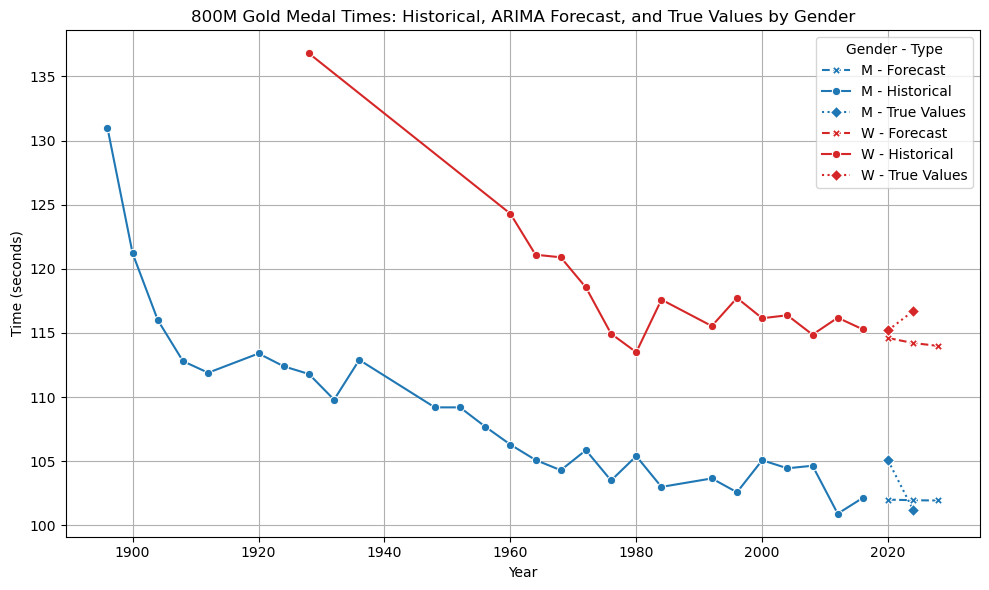

In [23]:
df = df_combined
import seaborn as sns
import matplotlib.pyplot as plt

gender_palette = {'M': 'tab:blue', 'W': 'tab:red'}

# marker and linestyle mappings by Type
type_linestyles = {
    'Historical': '-',
    'Forecast': '--',
    'True Values': ':'
}

type_markers = {
    'Historical': 'o',
    'Forecast': 'X',
    'True Values': 'D'
}

# Set up the figure
plt.figure(figsize=(10, 6))

# Plot each Gender + Type combination separately
for gender in df['Gender'].unique():
    for typ in df['Type'].unique():
        subset = df[(df['Gender'] == gender) & (df['Type'] == typ)]
        if not subset.empty:
            sns.lineplot(
                data=subset,
                x='Year',
                y='Forecast_Time_sec',
                label=f"{gender} - {typ}",
                color=gender_palette[gender],
                linestyle=type_linestyles[typ],
                marker=type_markers[typ]
            )

plt.title("800M Gold Medal Times: Historical, ARIMA Forecast, and True Values by Gender")
plt.xlabel("Year")
plt.ylabel("Time (seconds)")
plt.grid(True)
plt.legend(title="Gender - Type")
plt.tight_layout()
plt.show()


    Gender      Event               Location  Year Medal                 Name  \
803      M  5000M Men                    Rio  2016     G        Mohamed FARAH   
806      M  5000M Men                Beijing  2008     G      Kenenisa BEKELE   
809      M  5000M Men                 Sydney  2000     G         Millon WOLDE   
812      M  5000M Men              Barcelona  1992     G       Dieter BAUMANN   
815      M  5000M Men            Los Angeles  1984     G         SaÃ¯d AOUITA   
818      M  5000M Men               Montreal  1976     G          Lasse VIREN   
821      M  5000M Men                 Mexico  1968     G     Mohamed GAMMOUDI   
824      M  5000M Men                   Rome  1960     G       Murray HALBERG   
827      M  5000M Men               Helsinki  1952     G        Emil ZÃTOPEK   
830      M  5000M Men                 Berlin  1936     G      Gunnar HÃCKERT   
833      M  5000M Men              Amsterdam  1928     G         Ville RITOLA   
836      M  5000M Men       

/Users/avaduggan/miniconda3/envs/ds/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/Users/avaduggan/miniconda3/envs/ds/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/avaduggan/miniconda3/envs/ds/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/avaduggan/miniconda3/envs/ds/lib/python3.9/site-packages/statsmodels/tsa/deterministic.py:308: UserWarning: Only PeriodIndexes, DatetimeIndex

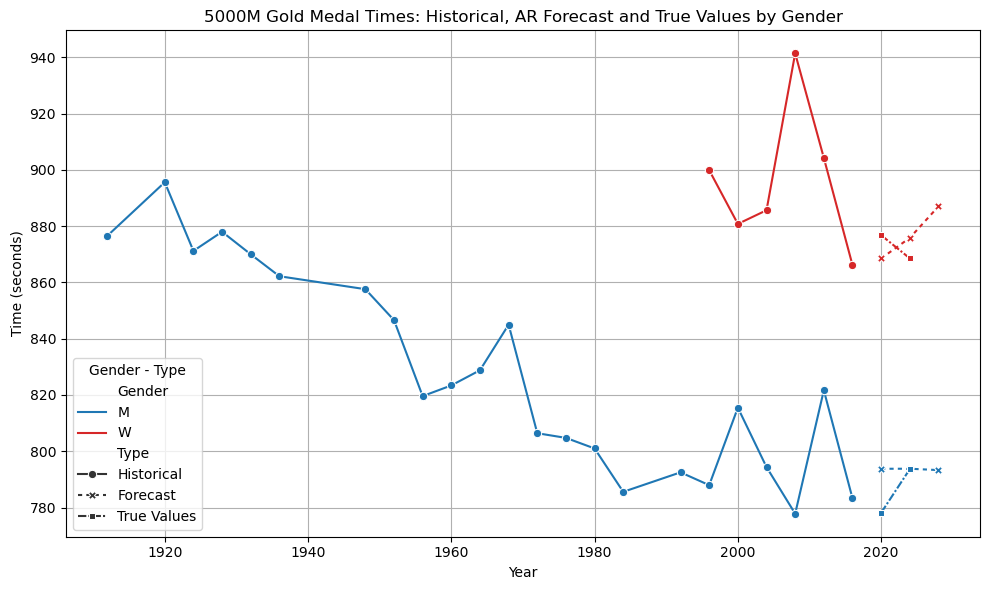

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.ar_model import AutoReg

#Collecting true data values for 5000M in 2020 and 2024
data = {'Event': ['5000M', '5000M', '5000M', '5000M'],'Year': [2020, 2024, 2020, 2024], 
        'Forecast_Time_sec': [778.15, 793.66, 876.79, 868.56], 'Gender': ['M', 'M', 'W', 'W'], 
        'Type': [ 'True Values','True Values','True Values','True Values']}
true_vals = pd.DataFrame(data)

# Define Olympic years to forecast
olympic_years = [2020, 2024, 2028]
event_base = "5000M"
all_results = []

# Filter only Gold medal performances
df = df.dropna(subset=['Medal'])
df = df[df['Medal'] == 'G']
df = df[df['Event'].isin([f"{event_base} Men", f"{event_base} Women"])]
# For both genders
for gender in ["M", "W"]:
    event_name = f"{event_base} {'Men' if gender == 'M' else 'Women'}"
    filtered = df[(df['Event'] == event_name) & (df['Gender'] == gender)]
    print(filtered)
    series = filtered[['Year', 'Result_sec']].dropna().sort_values('Year').drop_duplicates(subset='Year')
    if len(series) >= 5:  # AR models can work with less than 10 points
        ts = series.set_index('Year')['Result_sec']

        try:
            # Fit AR(p) model
            p = 2
            model = AutoReg(ts, lags=p, old_names=False)
            model_fit = model.fit()

            # Forecast future values
            steps = olympic_years[-1] - ts.index[-1]
            forecast = model_fit.predict(start=len(ts), end=len(ts) + steps - 1)
            forecast_years = list(range(ts.index[-1] + 1, ts.index[-1] + 1 + steps))
            forecast.index = forecast_years
            forecast = forecast[forecast.index.isin(olympic_years)]

            # Add historical
            for year, value in ts.items():
                all_results.append({
                    'Event': event_base,
                    'Gender': gender,
                    'Year': year,
                    'Forecast_Time_sec': value,
                    'Type': 'Historical'
                })

            # Add forecast
            for year, value in forecast.items():
                all_results.append({
                    'Event': event_base,
                    'Gender': gender,
                    'Year': year,
                    'Forecast_Time_sec': value,
                    'Type': 'Forecast'
                })
    

        except Exception as e:
            print(f"Error for {event_name}: {e}")
            continue
    else:
        print("not long enough")

# Create a combined DataFrame
df_result = pd.DataFrame(all_results)
df_result1 = pd.concat([df_result,true_vals], ignore_index = True)

# Plot
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=df_result1,
    x='Year',
    y='Forecast_Time_sec',
    hue='Gender',
    style='Type',
    markers=True,
    dashes={'Historical': '', 'Forecast': (2, 2), 'True Values': (4, 1, 1, 1)},
    palette={'M': 'tab:blue', 'W': 'tab:red'}
)

plt.title("5000M Gold Medal Times: Historical, AR Forecast and True Values by Gender")
plt.xlabel("Year")
plt.ylabel("Time (seconds)")
plt.grid(True)
plt.tight_layout()
plt.legend(title='Gender - Type')
plt.show()
